<a href="https://colab.research.google.com/github/SarahEverke/SarahEverke-IIC3633-2020/blob/master/practicos/Copia_de_pyreclab_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.youtube.com/watch?v=f5-ZMbTYZJQ" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: pyreclab - Funk's SVD

En este práctico implementaremos un recomendador basado en un algoritmo de factorización matricial propuesto por [Simon Funk](https://sifter.org/simon/journal/20061211.html).

Volveremos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile.

**Adaptado por**: Vladimir Araujo

**Material original de**: Denis Parra, Gabriel Sepúlveda, Antonio Ossa, Manuel Cartagena


## Configuración inicial

**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [ ]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    939      0 --:--:-- --:--:-- --:--:--   941
100 1546k  100 1546k    0     0  2048k      0 --:--:-- --:--:-- --:--:-- 2048k


In [ ]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1127      0 --:--:-- --:--:-- --:--:--  1127
100  385k  100  385k    0     0   606k      0 --:--:-- --:--:-- --:--:--  188M


In [ ]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    330      0 --:--:--  0:00:01 --:--:--   330
100  230k  100  230k    0     0   157k      0  0:00:01  0:00:01 --:--:-- 75.1M


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [ ]:
!pip install pyreclab --upgrade
#!pip install seaborn --upgrade

Requirement already up-to-date: pyreclab in /usr/local/lib/python3.6/dist-packages (0.1.14)


In [ ]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Antes de recomendar

**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [ ]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [ ]:
# Ahora queremos realizar una observación rápida de los datos
df_train.describe()

,userid,itemid,rating,timestamp
count,80000.000000,80000.000000,80000.000000,8.000000e+04
mean,494.508137,424.990487,3.526463,8.835467e+08
std,276.879511,330.564093,1.124429,5.379549e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,269.000000,174.000000,3.000000,8.794471e+08
50%,500.000000,321.000000,4.000000,8.828278e+08
75%,744.000000,630.000000,4.000000,8.884652e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [ ]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [ ]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Realizamos una inspección sobre estos datos (.info())
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [ ]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs
pelis = [5,4,1]
df_items.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

**Paso 4:** Generemos algunos gráficos en relación a las películas.

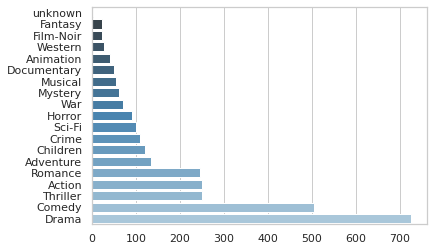

In [ ]:
#Ignorar el warning
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

Antes de trabajar con SVD, responda las siguientes preguntas.

**Pregunta:** Explique cómo funciona SVD (como modelo, no piense en la implementación), y cómo funciona el método `train()` en  `pyreclab`





**Respuesta:** 
El SVD aproxima los valores faltantes a través de una descomposición matricial. Para esto hace uso de factores latentes que pueden relacionarse con características de la base de datos. 
El train() hace la descomposición matricial y calcula los factores latentes.


## SVD

**Paso 5**: Tome un usuario, cualquiera, del dataset y reporte parte de sus gustos explícitamente (es decir, nombre de las películas, género, etc., no id). Para este mismo usuario, revise explícitamente las recomendaciones al llegar a la parametrización que reporta las mejores métricas.

In [ ]:
user_id = 2
user_df = df_train[df_train['userid'] == user_id]

df_items.loc[user_df['itemid'].values]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Antonia's Line (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Antonia%20(1995),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
237,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
255,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Definicion de objeto svd
svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# Entrenamiento del modelo
svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [ ]:
# Testing de predicciones
predlist, mae, rmse = svd.test(input_file='u2.test',
                               dlmchar=b'\t',
                               header=False,
                               usercol=0,
                               itemcol=1,
                               ratingcol=2)

print('MAE: {}\nRMSE: {}'.format(mae, rmse))

MAE: 0.720024648609182
RMSE: 0.9138383170163822


In [ ]:
# Testing de recomendaciones
top_n = 20

recommendList, maprec, ndcg = svd.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.11394943797202113
NDCG@20: 0.062158379105445784


In [ ]:
# Calcular las recomendaciones para el usuario escogido
ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [1512, 1449, 483, 408, 1367, 169, 64, 1467, 1558, 318, 1398, 480, 134, 12, 963, 187, 1500, 174, 923, 320]


In [ ]:
# Ver explicitamente las recomendaciones para un usuario
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
483,Casablanca (1942),01-Jan-1942,NaN,http://us.imdb.com/M/title-exact?Casablanca%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
408,"Close Shave, A (1995)",28-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Close%20Shave...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1558,Aparajito (1956),29-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Aparajito%20(...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


**Paso 6:** Pruebe distintos valores de los parámetros de entrenamiento del algoritmo SVD:
- Número de factores
- Número de iteraciones máxima
- Learning rate
- Lambda

Describa cómo estos afectan las métricas y las recomendaciones hechas para el usuario que escogió: *COMPLETAR*
- Al disminuir a 1 el número de factores aumentó el MAE de 0.72 a 0.73, pensé que la diferencia iba a ser mayor. Mientras que al usar 50 el MAE fue de 0.721
- Al usar 1 iteración la predicción empeoró porque el MAE due de 0.79. Mientras que con 1000 iteraciones el MAE obtenido correspondió a 0.721.
- Al usar un learning rate de 1, las métricas MAE y RMSE son nan (no comprendo bien porqué sucede eso) y sí entrega una lista con recomendaciones. Con 0.0001 el MAE aumenta a 0.79. Pensé que esta baja en el rendimiento se debía a que había un máximo de 100 iteraciones. Por eso, hice otra prueba con 0.0001 de learning rate y 1000 iteraciones, se demoró mucho más que el test anterior y se obtuvo un MAE de 0.74
- Tras usar un lambda de 0.05 el MAE fue de 0.73

In [ ]:
#Cambio de factor

svd = pyreclab.SVD(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)
# Pruebas:
# 0. Normal
# 1. Modifica factor
# 2. Modifica max_iter
# 3. Modifica l_rate
# 4. Modifica lambda
pruebas = [[100, 100, 0.01, 0.1], [1, 100, 0.01, 0.1], [100, 1, 0.01, 0.1], [100, 1000, 0.0001, 0.1], [100, 100, 0.01, 0.05]]

for i in range(5):
  svd.train(factors=pruebas[i][0], maxiter=pruebas[i][1], lr=pruebas[i][2], lamb=pruebas[i][3])
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                dlmchar=b'\t',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=2)
  ranking = [int(r) for r in svd.recommend(str(user_id), top_n, includeRated=False)]
  print('PRUEBA: {}\n MAE: {}\nRMSE: {}'.format(i, mae, rmse))
  print('Recommendation for user {}: {}'.format(user_id, ranking))
  print('-----')

PRUEBA: 0
 MAE: 0.7209058969164716
RMSE: 0.9145672000659321
Recommendation for user 2: [1512, 169, 1449, 408, 1398, 64, 1642, 1367, 318, 483, 12, 114, 1189, 1064, 174, 189, 963, 513, 172, 515]
-----
PRUEBA: 1
 MAE: 0.7308820496548941
RMSE: 0.926814088311435
Recommendation for user 2: [1512, 1449, 1467, 1500, 1367, 1536, 1642, 814, 408, 1398, 169, 1653, 114, 318, 1599, 1558, 1064, 64, 1639, 1524]
-----
PRUEBA: 2
 MAE: 0.795017594031483
RMSE: 0.993338405438897
Recommendation for user 2: [318, 12, 174, 64, 408, 172, 98, 357, 483, 173, 170, 603, 187, 496, 480, 178, 134, 474, 192, 199]
-----
PRUEBA: 3
 MAE: 0.7452758138843718
RMSE: 0.9421844558143649
Recommendation for user 2: [169, 408, 318, 483, 114, 64, 603, 12, 178, 513, 480, 923, 657, 515, 357, 174, 656, 474, 511, 427]
-----
PRUEBA: 4
 MAE: 0.7324491426485665
RMSE: 0.9327600859564779
Recommendation for user 2: [515, 64, 8, 1512, 169, 187, 318, 1, 408, 87, 189, 124, 1240, 1137, 1449, 498, 357, 657, 45, 521]
-----


**Paso 7:** Genere un gráfico explorando todos los parámetros que ofrece el modelo `SVD`, donde se grafiquen los valores probados para cada parámetro y el RMSE obtenido para cada uno. Debe probar una cantidad razonable de valores buscando la mejor parametrización y entregar el notebook con dicha parametrización.



In [ ]:
# Ejemplo
factor_values = [100, 150, 200] # definir distintos numeros de factores
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7206164889457418, 0.7202047622112672, 0.7202882916141142]
[0.9148080824553978, 0.9140291758000424, 0.913407925251565]


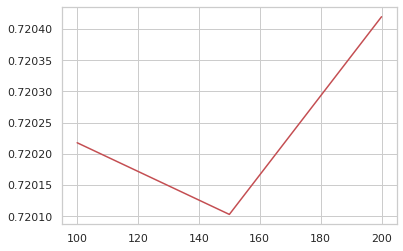

In [ ]:
plt.plot(factor_values, mae_values, 'r-')
plt.show()

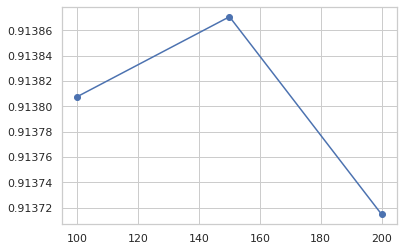

In [ ]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

**Paso 8:** Pruebe con otros valores y/o parámetros:

In [ ]:
# Para máximo de iteraciones
max_iter = [50, 100, 150, 200, 250, 300] 
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for iter in max_iter:
  svd.train(factors=100, maxiter=iter, lr=0.01, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7194596654969635, 0.7211873259221047, 0.7212596900550016, 0.7216716569979446, 0.7212980319582007, 0.7216097319028405]
[0.9135810335991892, 0.9154956845215947, 0.9150120245555764, 0.9157275121945402, 0.9151657357499496, 0.9156293766472982]


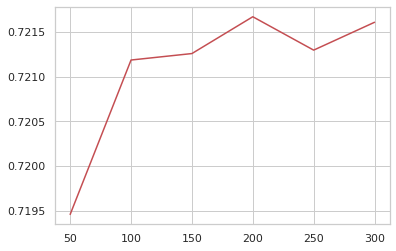

In [ ]:
plt.plot(max_iter, mae_values, 'r-')
plt.show()

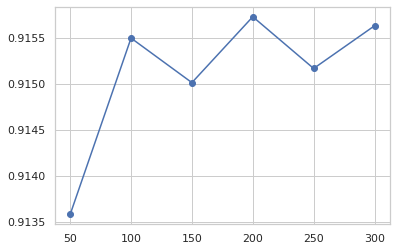

In [ ]:
plt.plot(max_iter, rmse_values, 'bo-')
plt.show()

In [ ]:
# Para learning rate
lr = [0.5, 0.01, 0.005, 0.001, 0.0005, 0.0001] 
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for r in lr:
  svd.train(factors=100, maxiter=50, lr=r, lamb=0.1)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[nan, 0.719030900361722, 0.7238222425008113, 0.7533664978839874, 0.7643735182721278, 0.8227419642399434]
[nan, 0.9127636079574531, 0.917956439290846, 0.9512909725596189, 0.9634164448775258, 1.0166875845688144]


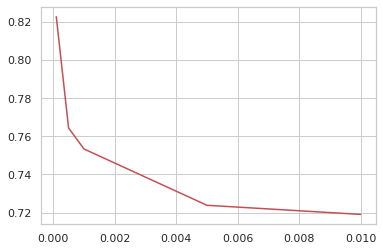

In [ ]:
plt.plot(lr, mae_values, 'r-')
plt.show()

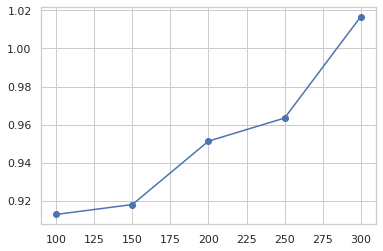

In [ ]:
plt.plot(max_iter, rmse_values, 'bo-')
plt.show()

In [ ]:
# Para lambda
lambdas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001] 
mae_values = [] # para almacenar resultados de MAP
rmse_values = [] # para almacenar valores de NDCG

for l in lambdas:
  svd.train(factors=100, maxiter=50, lr=0.01, lamb=l)
  
  predlist, mae, rmse = svd.test(input_file='u2.test',
                                 dlmchar=b'\t',
                                 header=False,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=2)
  
  mae_values.append(mae)
  rmse_values.append(rmse)

print(mae_values)
print(rmse_values)

[0.7745586419539191, 0.7205345337299631, 0.7320156351103408, 0.8070588858732909, 0.8350568756864284, 0.8650231902249753]
[0.9641169901790679, 0.9147044594694007, 0.9326484852172613, 1.0274183139506214, 1.0635742733462275, 1.1065006418033139]


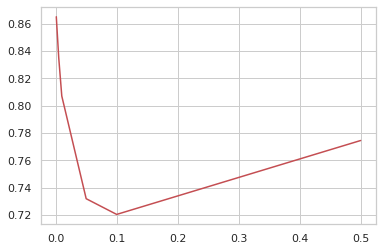

In [ ]:
plt.plot(lambdas, mae_values, 'r-')
plt.show()

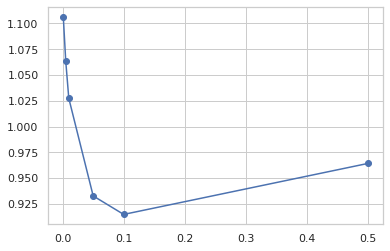

In [ ]:
plt.plot(lambdas, rmse_values, 'bo-')
plt.show()

El mejor resultado fue con (factors=100, maxiter=50, lr=0.01, lamb=0.1)